<h1> In this notebook, we will implement a neural network that regresses volume against segmentation + depth map </h1>

In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/root/alok/github/cv_research/alok')

import glob
import json
import os
import numpy as np
from PIL import Image

import keras
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist
from keras import backend as K
from keras.backend import tf as ktf

from matplotlib import pyplot as plt
from matplotlib import cm
from biomass_utils.points_of_interest import get_point_cloud

%matplotlib inline

os.environ["CUDA_VISIBLE_DEVICES"]="0"
np.random.seed(1)

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
# Get data ready

data_path_base = '/root/data/blender_v3'
image_dir = '{}/{}'.format(data_path_base, 'stereo_images')
depth_map_dir = '{}/{}'.format(data_path_base, 'depth_map')
segmentation_dir = '{}/{}'.format(data_path_base, 'mask')
annotation_dir = '{}/{}'.format(data_path_base, 'annotations')

number_key = lambda x: int(os.path.splitext(os.path.basename(x))[0].split('_')[-1])
side_key = lambda x: os.path.splitext(os.path.basename(x))[0].split('_')[0]
all_image_paths = sorted(glob.glob('{}/*.png'.format(image_dir)), key=number_key)
image_paths = [p for p in all_image_paths if side_key(p) == 'left'] # we are working with left frame only
all_segmentation_paths = sorted(glob.glob('{}/*.npy'.format(segmentation_dir)), key=number_key)
segmentation_paths = [p for p in all_segmentation_paths if side_key(p) == 'left'] # we are working with left frame only
depth_map_paths = sorted(glob.glob('{}/*.npy'.format(depth_map_dir)), key=number_key)
annotation_paths = sorted(glob.glob('{}/*.json'.format(annotation_dir)), key=number_key) 
complete_data_list = zip(image_paths, segmentation_paths, depth_map_paths, annotation_paths)


TRAINING_SIZE = 500
train_data_list = [v for i, v in enumerate(complete_data_list) if i < TRAINING_SIZE]
test_data_list = [v for i, v in enumerate(complete_data_list) if i > TRAINING_SIZE]


In [5]:
def convert_to_four_channel_input(image_array, segmentation_mask, depth_map, annotation):    
    projected_depth_map = get_point_cloud(depth_map, annotation['focal_length'], 
                                          annotation['sensor_height'], 
                                          annotation['sensor_width'])[:,:,1]
    cleaned_depth_map = segmentation_mask * projected_depth_map
    cleaned_depth_map = (cleaned_depth_map * (255.0 / 20)).astype('uint8')
    cleaned_depth_map_image = Image.fromarray(cleaned_depth_map)
    resized_depth_map_image = cleaned_depth_map_image.resize((224, 224))
    normalized_depth_map = np.array(resized_depth_map_image) / 255.0
    
    image = Image.fromarray(image_array)
    resized_image = image.resize((224, 224))
    normalized_image_array = np.array(resized_image) / 255.0
    
    four_channel_input = np.dstack([normalized_image_array, normalized_depth_map])
    
    return four_channel_input
        


In [6]:
idx = 0
a = convert_to_four_channel_input(np.array(Image.open(image_paths[idx]))[:,:,:3],
                                 np.load(segmentation_paths[idx]),
                                 np.load(depth_map_paths[idx]).T, 
                                 json.load(open(annotation_paths[idx], 'rb')))


In [7]:
def generator(data_list, steps_per_epoch, BATCH_SIZE, INPUT_SHAPE):
    i = 0
    while True:
        x_batch = np.empty((BATCH_SIZE, INPUT_SHAPE[0], INPUT_SHAPE[1], INPUT_SHAPE[2]))
        y_batch = np.empty((BATCH_SIZE, 1))
        for (ind, j) in enumerate(range(i*BATCH_SIZE, min((i+1)*BATCH_SIZE, len(data_list)))):
            image_array = np.array(Image.open(data_list[j][0]))[:,:,:3]
            segmentation_mask = np.load(data_list[j][1])
            depth_map = np.load(data_list[j][2]).T
            annotation = json.load(open(data_list[j][3], 'rb'))
            four_channel_input = convert_to_four_channel_input(image_array, segmentation_mask, depth_map, annotation)
            x_batch[ind, ...] = four_channel_input
            y_batch[ind] = annotation['volume']
            
        i += 1
        if i >= steps_per_epoch:
            i = 0
        yield x_batch, y_batch

In [8]:
# Generate a model with all layers (with top)
vgg16 = VGG16(weights=None, include_top=True, input_shape=(224, 224, 4))

#Add a layer where input is the output of the  second last layer 
x = Dense(1, name='predictions')(vgg16.layers[-2].output)

#Then create the corresponding model 
model = Model(input=vgg16.input, output=x)
model.summary()

/usr/local/lib/python2.7/dist-packages/keras/applications/imagenet_utils.py:258: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 4 input channels.
  str(input_shape[-1]) + ' input channels.')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 4)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      2368      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("pr..., inputs=Tensor("in...)`
  


In [15]:
optimizer = keras.optimizers.adam(lr=0.0001, decay=0.1)
model.compile(loss='mean_absolute_error',
              optimizer=optimizer,
              metrics=['accuracy'])

In [16]:
BATCH_SIZE = 25
steps_per_epoch = int(len(train_data_list)/BATCH_SIZE)
gen = generator(train_data_list, steps_per_epoch, BATCH_SIZE, (224, 224, 4))

In [17]:
model.fit_generator(gen, steps_per_epoch=steps_per_epoch, epochs=100, verbose=True)

Epoch 1/100
20/20 [==============================] - 42s 2s/step - loss: 1644.2930 - acc: 0.0000e+00
Epoch 2/100
20/20 [==============================] - 42s 2s/step - loss: 1375.3233 - acc: 0.0000e+00
Epoch 3/100
20/20 [==============================] - 42s 2s/step - loss: 1217.5719 - acc: 0.0000e+00
Epoch 4/100
20/20 [==============================] - 42s 2s/step - loss: 1108.7210 - acc: 0.0000e+00
Epoch 5/100
20/20 [==============================] - 42s 2s/step - loss: 1046.8420 - acc: 0.0000e+00
Epoch 6/100
20/20 [==============================] - 42s 2s/step - loss: 1001.2404 - acc: 0.0000e+00
Epoch 7/100
20/20 [==============================] - 42s 2s/step - loss: 963.6614 - acc: 0.0000e+00
Epoch 8/100
20/20 [==============================] - 42s 2s/step - loss: 933.5586 - acc: 0.0000e+00
Epoch 9/100
20/20 [==============================] - 42s 2s/step - loss: 906.9013 - acc: 0.0000e+00
Epoch 10/100
20/20 [==============================] - 42s 2s/step - loss: 882.6851 - acc: 0.00

20/20 [==============================] - 44s 2s/step - loss: 360.7724 - acc: 0.0000e+00
Epoch 83/100
20/20 [==============================] - 43s 2s/step - loss: 359.3113 - acc: 0.0000e+00
Epoch 84/100
20/20 [==============================] - 43s 2s/step - loss: 358.2132 - acc: 0.0000e+00
Epoch 85/100
20/20 [==============================] - 43s 2s/step - loss: 356.8689 - acc: 0.0000e+00
Epoch 86/100
20/20 [==============================] - 44s 2s/step - loss: 355.7309 - acc: 0.0000e+00
Epoch 87/100
20/20 [==============================] - 44s 2s/step - loss: 354.6149 - acc: 0.0000e+00
Epoch 88/100
20/20 [==============================] - 44s 2s/step - loss: 353.5052 - acc: 0.0000e+00
Epoch 89/100
20/20 [==============================] - 44s 2s/step - loss: 352.4655 - acc: 0.0000e+00
Epoch 90/100
20/20 [==============================] - 44s 2s/step - loss: 351.7993 - acc: 0.0000e+00
Epoch 91/100
20/20 [==============================] - 44s 2s/step - loss: 350.4800 - acc: 0.0000e+00
Epo

In [20]:
eval_gen = generator(test_data_list, np.inf, BATCH_SIZE, (224, 224, 4))
predictions = model.predict_generator(eval_gen, 50)

In [22]:
ground_truth_values = np.array([])
for i in range(50*25):
    annotation = json.load(open(test_data_list[i][3], 'rb'))
    ground_truth_values = np.append(ground_truth_values, annotation['volume'])

In [23]:
(ground_truth_values.mean() - predictions[:,0].mean())/(ground_truth_values.mean())

0.02831509463193507

In [27]:
ground_truth_values

array([2068.00994581, 1983.57114122, 5667.58181159, ...,  637.07885014,
       6112.66020444, 3667.47610275])

In [30]:
predictions[:,0]

array([2120.8235, 1951.4219, 5557.0576, ..., 1175.9847, 7262.849 ,
       6323.004 ], dtype=float32)

In [32]:
ground_truth_values.mean()

3339.447252546868

In [34]:
ground_truth_values

array([2068.00994581, 1983.57114122, 5667.58181159, ...,  637.07885014,
       6112.66020444, 3667.47610275])

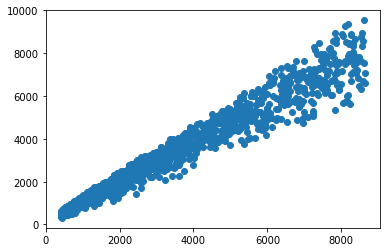

In [24]:
plt.scatter(ground_truth_values, predictions[:,0])

In [26]:
(abs(ground_truth_values - predictions[:,0])/(ground_truth_values)).mean()

0.12847042024702982

(array([494., 270., 193., 156., 137.]),
 array([ 411.3280957 , 2058.60891008, 3705.88972446, 5353.17053884,
        7000.45135321, 8647.73216759]),
 <a list of 5 Patch objects>)

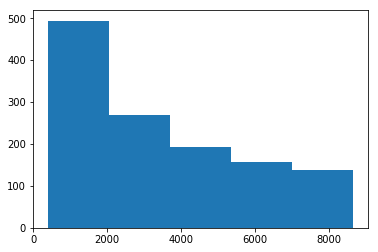

In [30]:
plt.hist(ground_truth_values, 5)

(array([517., 292., 232., 165.,  44.]),
 array([ 305.78674316, 2151.77080078, 3997.7548584 , 5843.73891602,
        7689.72297363, 9535.70703125]),
 <a list of 5 Patch objects>)

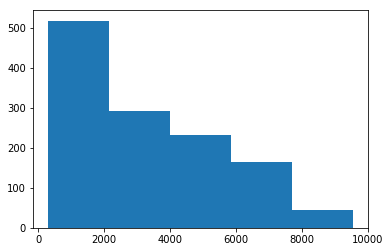

In [31]:
plt.hist(predictions[:,0], 5)